# Chapter06 학습 관련 기술들

In [43]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

### 6.1 매개변수 갱신

- 확률적 경사 하강법 (SGD) :

 $W ← W - \eta \frac{\partial L}{\partial W}$

 - $W$ : 갱신할 매개변수

 - $\eta$ : 학습률

 - $\frac{\partial L}{\partial W}$ : W에 대한 손실함수의 기울기

 기울어진 방향으로 일정 거리만 가겠다는 단순한 방법

In [44]:
# SGD 구현
class SGD(object):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):   # 갱신
        for key in params.keys():
            params[key] -= self.lr * grads[key]

    # SGD 과정에서 반복해서 update()메서드를 부른다

SGD 클래스를 사용하면 신경망의 매개변수 진행을 다음과 같이 수행할 수 있다.

    network = TwoLayerNet(...)
    optimizer = SGD()

    for i in range(10000):
        ...
        x_batch, t_batch = get_mini_batch(...)
        grads = network.gradient(x_batch, t_batch)
        params = network.params
        optimizer.update(params, grads)
        ...
    
이렇게 optimizer에 매개변수와 기울기만 전달해주면 된다.

---

SGD의 단점 : 비등방성 함수에서 탐색 경로가 비효율적이다. ( 지그재그로 탐색 )

- **모멘텀** : 

 $v ← \alpha v - \eta \frac{\partial L}{\partial W}$

 $W ← W + v$

In [45]:
# 모멘텀 구현

class Momentum(object):
    def __init__(self, lr=0.01, momentum=0.9):  # 대체로 momentum=0.9로 설정
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):    
        if self.v is None:      # v: 0으로 초기화 
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]
        
# v는 이전 갱신에 영향을 받게 되며, 이전 갱신값이 크다면, 이번에 그만큼 가속도를 받게 된다

학습률 감소 : 학습을 진행하면서 학습률을 점차 줄여가는 방법

- **AdaGrad** : '각각의' 매개변수에 '맞춤형' 값을 만들어줌

 $h ← h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W}$  (⊙ : 원소별 곱셈)

 $W ← W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$

 크게 갱신된 원소는 큰 폭으로 학습률이 낮아진다. (학습률 감소가 원소마다 다르게 적용됨)

 AdaGrad는 과거의 기울기를 제곱하여 계속 더해간다. (누적합) ---> 실제로 무한히 학습하면 갱신량이 0이 되어 갱신 X

 - **RMSProp** 기법 : 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영 (지수이동평균)

In [46]:
# Adagrad 구현

class AdaGrad(object):
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

- **Adam** : 모멘텀과 AdaGrad를 융합한 방법

In [47]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [48]:
path = "/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master"
os.chdir(path)
sys.path.append(os.chdir)

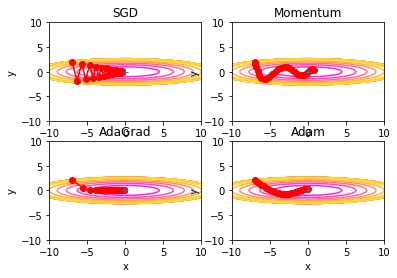

In [49]:
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()